# For SOSE

In [1]:
from dask_gateway import Gateway

g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.ec7bc449bb6542e5801559eea804872b/status,


In [3]:
client.close()
cluster.close()

SyntaxError: unmatched ')' (3374967276.py, line 1)

In [7]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import json

In [8]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

# Validating Heat Budget (w zarr ds)

In [9]:
ds_tmp = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/budget_th.zarr'))
ds_tmp

/tmp/ipykernel_1268/1836856486.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds_tmp = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/budget_th.zarr'))


,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,439 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,439 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [10]:
ds_tmp = ds_tmp.roll(XC=700)

/tmp/ipykernel_1268/3756762742.py:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_tmp = ds_tmp.roll(XC=700)


### Entire WG column budget

In [11]:
#mark 3
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

In [12]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [13]:
ds_tmp_wg = ds_tmp.isel(**lat_range, **lon_range)
ds_tmp_wg

,Array,Chunk
Bytes,3.71 GiB,8.68 MiB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,3067 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.71 GiB,8.68 MiB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,3067 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [25]:
rhs_heat = ((ds_tmp_wg.conv_horiz_adv_flux_TH + 
             ds_tmp_wg.conv_horiz_diff_flux_TH +
             ds_tmp_wg.sw_flux_conv_TH + 
             ds_tmp_wg.lin_fs_correction_TH + 
             ds_tmp_wg.surface_flux_conv_TH).sum(dim=['XC', 'YC', 'Z'])).load()

In [17]:
lhs_heat = ds_tmp_wg.total_tendency_TH_truth.sum(dim=['XC', 'YC', 'Z']).load()

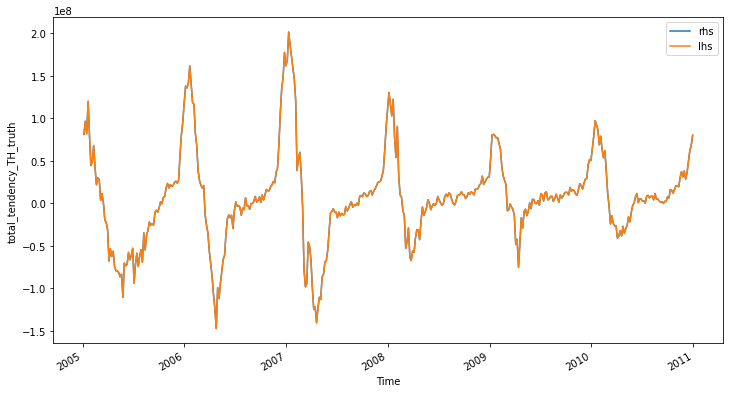

In [26]:
plt.figure(figsize=(12,6))
rhs_heat.plot(label='rhs')
lhs_heat.plot(label='lhs')
plt.legend();

In [23]:
rhs =  (budget_th.surface_flux_conv_TH
        + budget_th.conv_horiz_adv_flux_TH + budget_th.conv_vert_adv_flux_TH
        + budget_th.conv_horiz_diff_flux_TH + budget_th.conv_vert_diff_flux_TH
        + budget_th.sw_flux_conv_TH + budget_th.lin_fs_correction_TH)
lhs = budget_th.total_tendency_TH_truth

In [64]:
rhs_heat = (ds_tmp_wg.conv_horiz_adv_flux_TH + 
            ds_tmp_wg.conv_vert_adv_flux_TH +
             ds_tmp_wg.conv_horiz_diff_flux_TH +
            ds_tmp_wg.conv_vert_diff_flux_TH +
             ds_tmp_wg.sw_flux_conv_TH + 
             ds_tmp_wg.lin_fs_correction_TH + 
             ds_tmp_wg.surface_flux_conv_TH)

In [60]:
lhs_heat = ds_tmp_wg.total_tendency_TH_truth

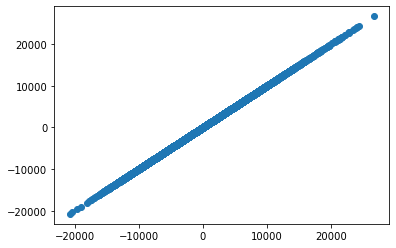

In [65]:
plt.scatter(rhs_heat.isel(time=35).values.ravel(), lhs_heat.isel(time=35).values.ravel())

### Interior WG column budget

In [14]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 0
upper_lat_lower = 95
left_lon_lower = 310
right_lon_lower = 880

lower_cell_range = dict(Zl=[27, 42])
lower_cell_range_z = dict(Z=slice(27, 42))

In [15]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))

In [16]:
ds_tmp_wg_lower = ds_tmp.isel(**lat_range_lower, **lon_range_lower, **lower_cell_range_z)
ds_tmp_wg_lower

<xarray.Dataset>
Dimensions:                  (XC: 570, YC: 95, Z: 15, time: 438)
Coordinates:
  * XC                       (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                       (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                        (Z) float32 -2046.0 -2319.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    sw_flux_conv_TH          (time, YC, XC, Z) float32 dask.array<chunksize=(1, 95, 570, 15), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 15, 95, 570), meta=np.ndarray>

In [17]:
rhs_heat_lower = ((ds_tmp_wg_lower.conv_horiz_adv_flux_TH + 
                  ds_tmp_wg_lower.conv_horiz_diff_flux_TH + 
                  ds_tmp_wg_lower.conv_vert_adv_flux_TH +
                  ds_tmp_wg_lower.conv_vert_diff_flux_TH).sum(dim=['XC', 'YC', 'Z'])).load()
                  
lhs_heat_lower = ds_tmp_wg_lower.total_tendency_TH_truth.sum(dim=['XC', 'YC', 'Z']).load()

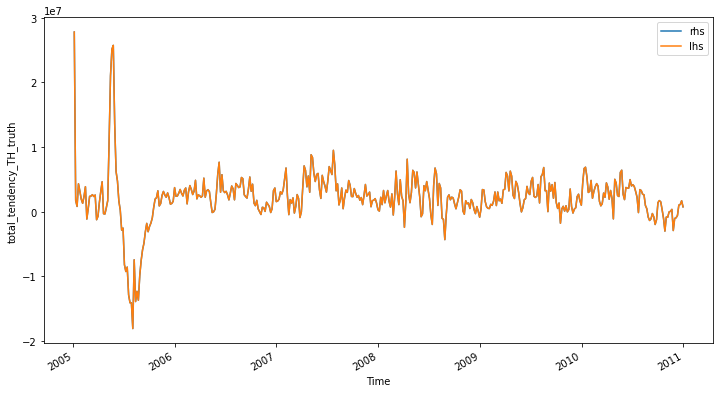

In [18]:
plt.figure(figsize=(12,6))
rhs_heat_lower.plot(label='rhs')
lhs_heat_lower.plot(label='lhs')
plt.legend();

# Validating Salt Budget (w zarr ds)

In [27]:
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_slt.zarr'))
ds_slt

/tmp/ipykernel_1268/4020196727.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_slt.zarr'))


,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,439 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,439 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [28]:
ds_slt = ds_slt.roll(XC=700)

/tmp/ipykernel_1268/621519313.py:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_slt = ds_slt.roll(XC=700)


### Entire WG column budget

In [29]:
ds_slt_wg = ds_slt.isel(**lat_range, **lon_range)
ds_slt_wg

,Array,Chunk
Bytes,3.71 GiB,8.68 MiB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,3067 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.71 GiB,8.68 MiB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,3067 Tasks,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


**Errors & Corrections:**
- corrected boundaries so that comparison with old salt budget could be accurate
- realized I shouldn't be including vertical terms for entire water column
- compared each term's plot with old salt budget (they all matched)
- what finally worked was the fact that I can't sum over 'Z' dimension for the surface terms... why is that? - because when I did that the plot didn't math lhs.

In [38]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.ec7bc449bb6542e5801559eea804872b/status,


In [39]:
rhs_slt = ((ds_slt_wg.conv_horiz_adv_flux_SLT + 
            ds_slt_wg.conv_horiz_diff_flux_SLT +
            ds_slt_wg.lin_fs_correction_SLT + 
            ds_slt_wg.surface_flux_conv_SLT).sum(dim=['XC', 'YC', 'Z'])).load()

In [36]:
lhs_slt = ds_slt_wg.total_tendency_SLT_truth.sum(dim=['XC', 'YC', 'Z']).load()

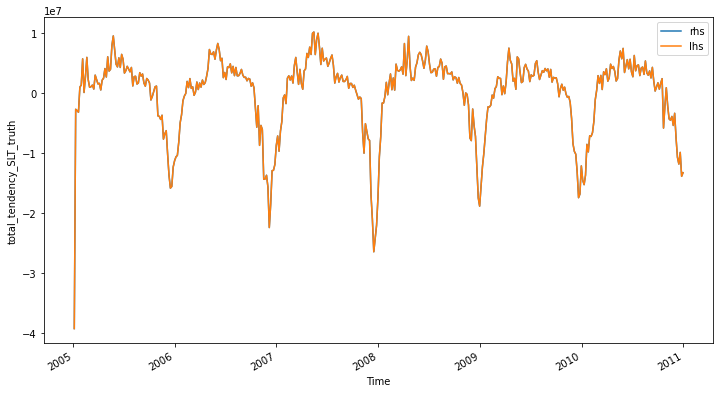

In [40]:
plt.figure(figsize=(12,6))
rhs_slt.plot(label='rhs')
lhs_slt.plot(label='lhs')
plt.legend();

In [66]:
rhs_slt_wg = (ds_slt_wg.conv_horiz_adv_flux_SLT + 
              ds_slt_wg.conv_vert_adv_flux_SLT +
            ds_slt_wg.conv_horiz_diff_flux_SLT +
              ds_slt_wg.conv_vert_diff_flux_SLT +
            ds_slt_wg.lin_fs_correction_SLT + 
            ds_slt_wg.surface_flux_conv_SLT)

In [44]:
lhs_slt_wg = ds_slt_wg.total_tendency_SLT_truth

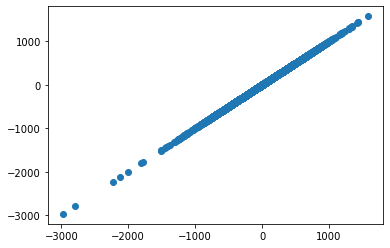

In [67]:
plt.scatter(rhs_slt_wg.isel(time=35).values.ravel(), lhs_slt_wg.isel(time=35).values.ravel())

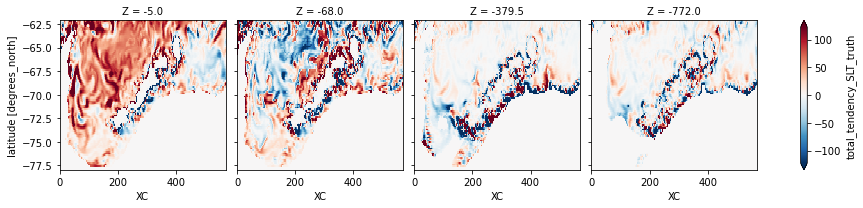

In [46]:
lhs_slt_wg.isel(time=35, Z=[0, 5, 15, 20]).drop('XC').plot(robust=True, col='Z')

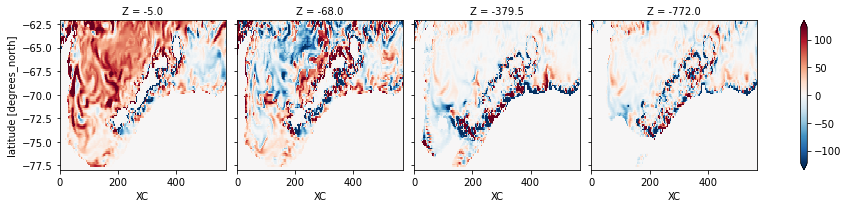

In [68]:
rhs_slt_wg.isel(time=35, Z=[0, 5, 15, 20]).drop('XC').plot(robust=True, col='Z')

In [69]:
rhs_slt_wg

,Array,Chunk
Bytes,3.71 GiB,8.68 MiB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,20592 Tasks,438 Chunks
Type,float32,numpy.ndarray


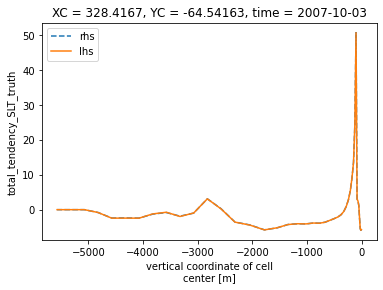

In [70]:
rhs_slt_wg[200,:,80,200].plot(label='rhs', linestyle='--')
lhs_slt_wg[200,:,80,200].plot(label='lhs')
plt.legend()

### Interior WG column budget

In [24]:
ds_slt_wg_lower = ds_slt.isel(**lat_range_lower, **lon_range_lower, **lower_cell_range_z)
ds_slt_wg_lower

<xarray.Dataset>
Dimensions:                   (XC: 570, YC: 95, Z: 15, time: 438)
Coordinates:
  * XC                        (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                        (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                         (Z) float32 -2046.0 -2319.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 15, 95, 570), meta=np.ndarray>

In [25]:
rhs_slt_lower = (ds_slt_wg_lower.conv_horiz_adv_flux_SLT + 
                 ds_slt_wg_lower.conv_horiz_diff_flux_SLT + 
                 ds_slt_wg_lower.conv_vert_adv_flux_SLT +
                 ds_slt_wg_lower.conv_vert_diff_flux_SLT).sum(dim=['XC', 'YC', 'Z']).load()

lhs_slt_lower = ds_slt_wg_lower.total_tendency_SLT_truth.sum(dim=['XC', 'YC', 'Z']).load()

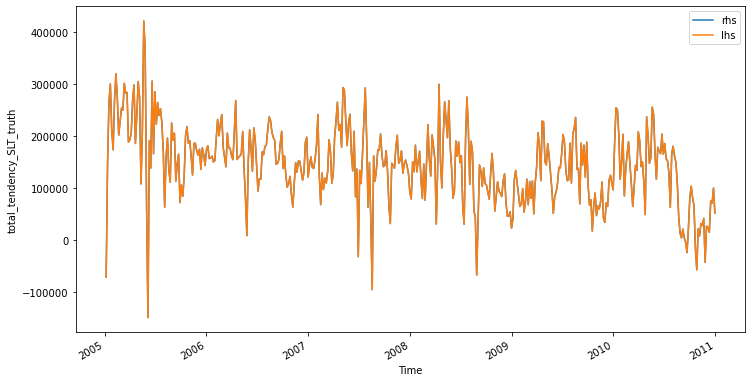

In [26]:
plt.figure(figsize=(12,6))
rhs_slt_lower.plot(label='rhs')
lhs_slt_lower.plot(label='lhs')
plt.legend();